### Import libraries

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import os
import astropy.convolution as krn
import scipy.stats as stats
import seaborn as sns

In [4]:
def makeHeat(screenRes, xPos, yPos):
        xMax = screenRes[0]
        yMax = screenRes[1]
        xMin = 0
        yMin = 0
        kernelPar = 50

        # Input handeling
        xlim = np.logical_and(xPos < xMax, xPos > xMin)
        ylim = np.logical_and(yPos < yMax, yPos > yMin)
        xyLim = np.logical_and(xlim, ylim)
        dataX = xPos[xyLim]
        dataX = np.floor(dataX)
        dataY = yPos[xyLim]
        dataY = np.floor(dataY)

        # initiate map and gauskernel
        gazeMap = np.zeros([int((xMax-xMin)),int((yMax-yMin))])+0.0001
        gausKernel = krn.Gaussian2DKernel(kernelPar)

        # Rescale the position vectors (if xmin or ymin != 0)
        dataX -= xMin
        dataY -= yMin

        # Now extract all the unique positions and number of samples
        xy = np.vstack((dataX, dataY)).T
        uniqueXY, idx, counts = uniqueRows(xy)
        uniqueXY = uniqueXY.astype(int)
        # populate the gazeMap
        gazeMap[uniqueXY[:,0], uniqueXY[:,1]] = counts

        # Convolve the gaze with the gauskernel
        heatMap = np.transpose(krn.convolve_fft(gazeMap,gausKernel))
        heatMap = heatMap/np.max(heatMap)

        return heatMap

def uniqueRows(x):
    y = np.ascontiguousarray(x).view(np.dtype((np.void, x.dtype.itemsize * x.shape[1])))
    _, idx, counts = np.unique(y, return_index=True, return_counts = True)
    uniques = x[idx]
    return uniques, idx, counts


def np_euclidean_distance(y_true, y_pred):

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    return np.sqrt(np.sum(np.square(y_pred - y_true), axis=-1))



### Preprocess files and make dataframe
1. Extract datasets based on the header row
2. Label 25-dot dataset based on 9-dot calibration as 25_9, and on 13-dot calibration as 25_13
3. Participants had 3 attempts to get calibration <3 cm. Keep only the successful calibration dataset (total=4)
4. Scale pixels to standard dimensions. Calibration dots were presented as % display size in px
5. Convert pixels to cm
6. Assign each dot a unique label



In [5]:
# Path to data folders
path_to_folders = 'C:/Users/artem/Dropbox/DeepEye_Pilots/VBL_Exp1/data/approved/data'


# get all folder names
folder_names = os.listdir(path_to_folders)

pp_list = []
num_calib_attemtps = []
for fn in folder_names:
    path = os.path.join(path_to_folders, fn, fn+'_test_all.csv')       
        
    try: 
        df = pd.read_csv(path)        
    
    except:
        continue
    
    
    # Find the headers via duplicates and use it to split into datasets   
    mask_dup = df.duplicated(keep=False)
    # Make indices of datasets
    idx_dup = df.index[mask_dup == True].tolist()
    idx_dup[:0] = [-1] # add lower index
    idx_dup.extend([df.shape[0]]) # add upper index
    
    # Use indices to parse datasets
    df_list = []
    count_datasets = 0
    last_numCalibDots = []
    
    for i in range(len(idx_dup)):
        if i < len(idx_dup) - 1:
            a = df.iloc[idx_dup[i]+1:idx_dup[i+1]]
            a = a.apply(pd.to_numeric, errors='coerce') # when header is written twice, some floats are str, fix this
            a.dropna(subset=['numCalibDots'], inplace=True) # drop rows where numCalibDots = NaN
            a['numCalibDots'] = a['numCalibDots'].astype(int)
            a = a[a.numCalibDots < 25]
            a['dataset_num'] = count_datasets
            

            a['eucl_dist_px_orig'] = np_euclidean_distance(np.array(a[['x','y']]), np.array(a[['user_pred_px_x','user_pred_px_y']]))
            scale_cm_in_px = a.scrW_cm/a.resX
            a['eucl_dist_cm_orig'] = a.eucl_dist_px_orig * scale_cm_in_px 
            
            # if pd.api.types.is_string_dtype(a.sona_pp_id) == True:
            #     a['platform'] = 'PROLIFIC'
            # else:
            #     a['platform'] = 'SONA'
           
            # Label 25-dot conditions based on preceeding dataset
            if a.numCalibDots.iloc[0] == 25:
                # print(f'last: {last_numCalibDots[-1]}')
                if last_numCalibDots[-1] == 9:
                    a['condition'] = '25_9'
                elif last_numCalibDots[-1] == 13:
                    a['condition'] = '25_13'                
            else:
                a['condition'] = a.numCalibDots.astype(str)
                
            last_numCalibDots.append(a.numCalibDots.iloc[-1]) # log last value                
            
            # Accumulate all dataset per subject
            df_list.append(a)
            count_datasets += 1
    
    
    # if there are more than 4 datasets, remove the recalibrated ones, pick the last one
    last_numCalibDots = pd.Series(last_numCalibDots)
    idx_good_datasets = last_numCalibDots.loc[last_numCalibDots.shift(-1) != last_numCalibDots] # shift dataset by one row and get indices
    df_list = [df_list[i] for i in list(idx_good_datasets.index)] # pick only the 4 datasets
    # assert(len(df_list) == 4)
    
    # Concatenate all datasets per subject
    b = pd.concat(df_list)
    
    # Add a subj_nr column
    b['subj_nr'] = fn    
    
    # Count the number of calibration attempts per participant in a new df
    unique, counts = np.unique(last_numCalibDots, return_counts=True)
    c = pd.DataFrame(np.asarray((unique, counts)).T, columns=['num_calib_dots', 'frequency'])
    c['subj_nr'] = fn
    num_calib_attemtps.append(c)
    num_calib_attempts_df = pd.concat(num_calib_attemtps).reset_index(drop=True)
    
        
    # Accumulate datasets across subjects
    pp_list.append(b)

# Concatenate all subjects in one df
df_all = pd.concat(pp_list)
df_all = df_all.reset_index()


"""
'2023_04_15_11_42_39' - amazing performance, but did not do 25_9
"""
# Exclude subjects
df_all = df_all[df_all.subj_nr != '2023_04_07_13_59_57'] # my pilot data
df_all = df_all[df_all.subj_nr != '2023_04_07_13_45_47'] # my pilot data

# Convert coordinates to standard resolution (target_resX and target_resY)
# Every display resolution is scaled to this one since all dots are drawn in % display size in px
target_resX = df_all.resX.iloc[0] #1280.0
target_resY = df_all.resY.iloc[0] #800.0

df_all['user_pred_px_x_scaled'] = df_all.user_pred_px_x/df_all.resX * target_resX
df_all['user_pred_px_y_scaled'] = df_all.user_pred_px_y/df_all.resY * target_resY

df_all['x_scaled'] = np.round(df_all.x/df_all.resX * target_resX)
df_all['y_scaled'] = np.round(df_all.y/df_all.resY * target_resY)

# Get an average scale for converting to px to cm
df_all['scale_cm_in_px'] = df_all.scrW_cm.astype(float)/df_all.resX.astype(float)
scale_cm_in_px = df_all.scale_cm_in_px.mean() # average scaling factor

# Get indices of unique dot positions (unique rows)
u, indices = np.unique(np.array([df_all.x_scaled, df_all.y_scaled]).T, axis=0, return_inverse=True)
df_all['unique_dot'] = indices

### Plot heatmaps per each condition
Gaze positions for all subjects are combined

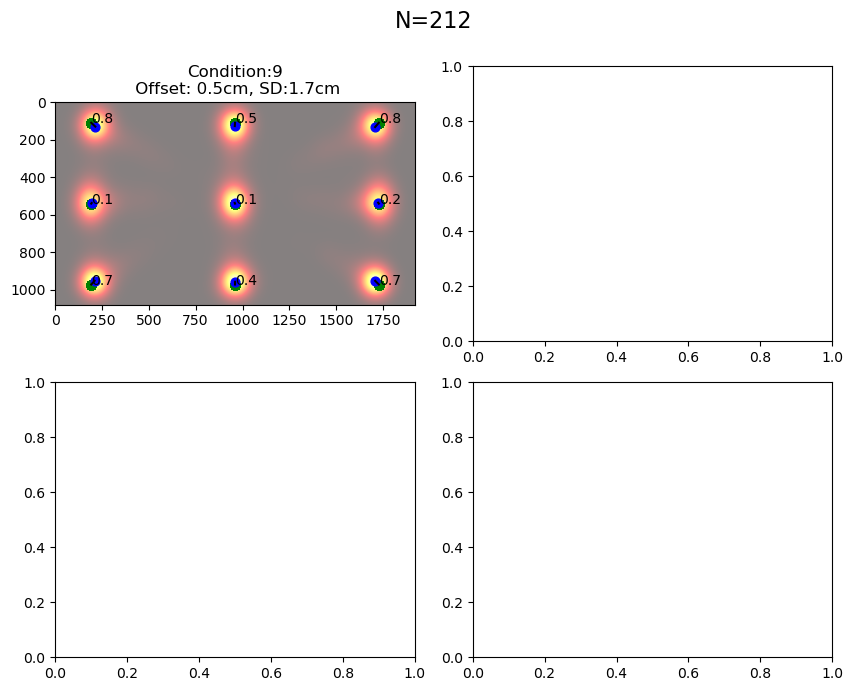

In [6]:
fig2, ax2 = plt.subplots(nrows=2, ncols=2)
fig2.set_size_inches((8.5, 7.0), forward=False)
fig2.tight_layout()

subplot_cell = [[0,0],[0,1],[1,0], [1,1]] 

count_plots2 = 0

# Iterate per condition
for name, df in df_all.groupby('condition'):

    # Make heatmap of all gaze points of all subjects
    heatmap = makeHeat([target_resX, target_resY], np.array(df.user_pred_px_x_scaled), np.array(df.user_pred_px_y_scaled))    
    
    # Get median gaze prediction per dot
    median_pred_x = df.groupby('unique_dot').user_pred_px_x_scaled.median()
    median_pred_y = df.groupby('unique_dot').user_pred_px_y_scaled.median()  
             
    # Get ground truth per each dot
    true_x = df.groupby('unique_dot').x_scaled.mean()
    true_y = df.groupby('unique_dot').y_scaled.mean()   
        
    # calculate the distance between median gaze prediction to ground truth per each dot
    offset = np_euclidean_distance(np.array([median_pred_x, median_pred_y]).T, np.array([true_x, true_y]).T)    
   
    # Convert to cm
    offset_cm = offset *  scale_cm_in_px
    
    # Compute SD   
    median_pred = df.groupby('unique_dot')[['user_pred_px_x_scaled','user_pred_px_y_scaled']].median()
    median_pred.columns = ['median_pred_x', 'median_pred_y'] 
    # Add median prediction per dot into the original df
    df = pd.merge(df, median_pred, on="unique_dot", how="left")
    
    # Compute euclidean distance from each gaze sample to median gaze for each dot  
    df['eucl_dist_gaze_to_median_px'] = np_euclidean_distance(np.array([df.user_pred_px_x_scaled, df.user_pred_px_y_scaled]).T, 
                                                             np.array([df.median_pred_x, df.median_pred_y]).T)
    
    # Average e.d. for each dot
    SD = df.groupby('unique_dot').eucl_dist_gaze_to_median_px.mean()
    SD_cm = SD * scale_cm_in_px
    
    # Get subplot coordinates
    row = subplot_cell[count_plots2][0]
    column = subplot_cell[count_plots2][1]
    
    # Plot heatmap for current condition
    ax2[row, column].imshow(heatmap, cmap=cm.hot, extent=[0, target_resX, target_resY, 0], alpha = 0.5, aspect='equal')  
    # Plot true pos and predicted median errors, lines
    ax2[row, column].scatter(df.x_scaled, df.y_scaled, c='g', s=40, alpha=0.5)
    ax2[row, column].scatter(median_pred_x, median_pred_y, c='b', s=40)
    ax2[row, column].plot([median_pred_x, true_x], [median_pred_y, true_y], c='black')
    # Title
    ax2[row, column].set_title(f'Condition:{df.condition.iloc[0]}\n Offset: {np.round(offset_cm.mean(),1)}cm, SD:{np.round(SD_cm.mean(),1)}cm')
    
    # Plot offset values for each dot
    for x,y,e in zip(np.array(true_x), np.array(true_y), np.round(offset_cm, 1)):
        ax2[row, column].text(x, y, e, fontsize=10)
    
    count_plots2 += 1      
  
    
 # Save plot
fig2.suptitle(f'N={df.subj_nr.unique().size}', fontsize=16)
fig2.subplots_adjust(top=0.9)
# fig2.savefig('calibration.jpg', dpi=1000, pad_inches=0)


Text(0.5, 0.98, 'N=212')

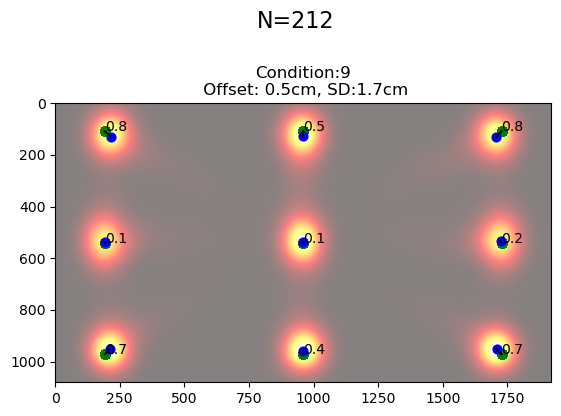

In [7]:

# Iterate per condition
for name, df in df_all.groupby('condition'):

    # Make heatmap of all gaze points of all subjects
    heatmap = makeHeat([target_resX, target_resY], np.array(df.user_pred_px_x_scaled), np.array(df.user_pred_px_y_scaled))    
    
    # Get median gaze prediction per dot
    median_pred_x = df.groupby('unique_dot').user_pred_px_x_scaled.median()
    median_pred_y = df.groupby('unique_dot').user_pred_px_y_scaled.median()  
             
    # Get ground truth per each dot
    true_x = df.groupby('unique_dot').x_scaled.mean()
    true_y = df.groupby('unique_dot').y_scaled.mean()   
        
    # calculate the distance between median gaze prediction to ground truth per each dot
    offset = np_euclidean_distance(np.array([median_pred_x, median_pred_y]).T, np.array([true_x, true_y]).T)    
   
    # Convert to cm
    offset_cm = offset *  scale_cm_in_px
    
    # Compute SD   
    median_pred = df.groupby('unique_dot')[['user_pred_px_x_scaled','user_pred_px_y_scaled']].median()
    median_pred.columns = ['median_pred_x', 'median_pred_y'] 
    # Add median prediction per dot into the original df
    df = pd.merge(df, median_pred, on="unique_dot", how="left")
    
    # Compute euclidean distance from each gaze sample to median gaze for each dot  
    df['eucl_dist_gaze_to_median_px'] = np_euclidean_distance(np.array([df.user_pred_px_x_scaled, df.user_pred_px_y_scaled]).T, 
                                                             np.array([df.median_pred_x, df.median_pred_y]).T)
    
    # Average e.d. for each dot
    SD = df.groupby('unique_dot').eucl_dist_gaze_to_median_px.mean()
    SD_cm = SD * scale_cm_in_px
    
    # Get subplot coordinates
    # row = subplot_cell[count_plots2][0]
    # column = subplot_cell[count_plots2][1]
    
    # Plot heatmap for current condition
    plt.figure()

    plt.imshow(heatmap, cmap=cm.hot, extent=[0, target_resX, target_resY, 0], alpha = 0.5, aspect='equal')  
    # Plot true pos and predicted median errors, lines
    plt.scatter(df.x_scaled, df.y_scaled, c='g', s=40, alpha=0.5)
    plt.scatter(median_pred_x, median_pred_y, c='b', s=40)
    plt.plot([median_pred_x, true_x], [median_pred_y, true_y], c='black')
    # Title
    plt.title(f'Condition:{df.condition.iloc[0]}\n Offset: {np.round(offset_cm.mean(),1)}cm, SD:{np.round(SD_cm.mean(),1)}cm')
    
    # Plot offset values for each dot
    for x,y,e in zip(np.array(true_x), np.array(true_y), np.round(offset_cm, 1)):
        plt.text(x, y, e, fontsize=10)
    
    count_plots2 += 1      
  
    
 # Save plot
plt.suptitle(f'N={df.subj_nr.unique().size}', fontsize=16)

# fig2.savefig('calibration.jpg', dpi=1000, pad_inches=0)

### Calculate and plot offsets and SD per condition per subject

1. Offset - euclidean distance from the median gaze prediction per each dot to the ground truth
2. SD - mean of euclidean distances from each gaze prediction to the median gaze prediction for each dot

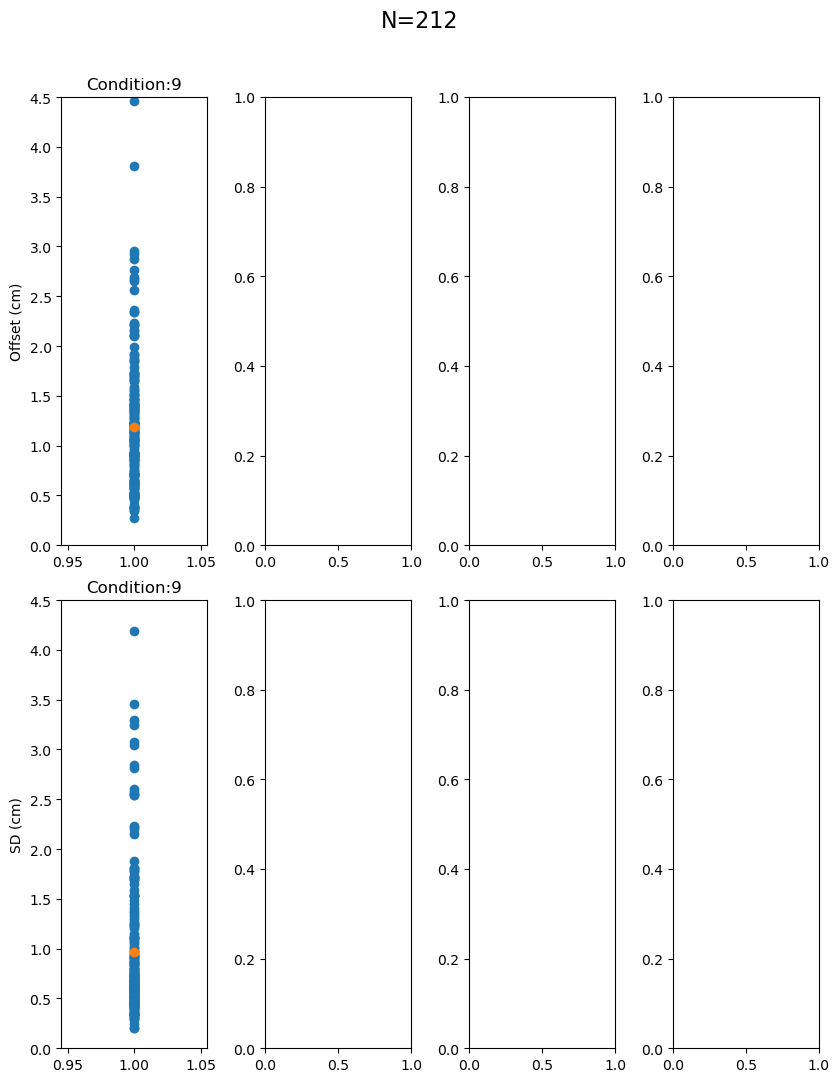

In [8]:
fig, ax = plt.subplots(nrows=2, ncols=4)
fig.set_size_inches((8.5, 11), forward=False)


# Loop thru each condition
count_plots = 0
summary_df_all = []

for name, i in df_all.groupby('condition'):
    
    # df for all subjects for each condition
    summary_df = []    
   
    # Loop thru each subject and unique dot
    for _, j in i.groupby(['subj_nr', 'unique_dot']):
        
        # Get median gaze for each unique dot in pixels
        j['median_pred_x'] = j.user_pred_px_x_scaled.median()
        j['median_pred_y'] = j.user_pred_px_y_scaled.median()
        
        # Get euclidean distance from each gaze sample to median gaze for each dot
        j['eucl_dist_gaze_to_median_px'] = np_euclidean_distance(np.array([j.user_pred_px_x_scaled, j.user_pred_px_y_scaled]).T, 
                              np.array([j.median_pred_x, j.median_pred_y]).T)        
        j['eucl_dist_gaze_to_median_cm'] = j.eucl_dist_gaze_to_median_px * scale_cm_in_px
        
        # Get euclidean distance from median gaze to ground truth (accuracy)
        j['offset_px'] = np_euclidean_distance(np.array([j.median_pred_x, j.median_pred_y]).T, np.array([j.x_scaled, j.y_scaled]).T)  
        j['offset_cm'] = j.offset_px * scale_cm_in_px
        
        summary_df.append(j)        
    
    # Concatenate datasets from all subjects  
    summary_df = pd.concat(summary_df)
    
    # Get STD (mean distance of gaze_to_median per subject)
    agg_SD = summary_df.groupby(['subj_nr'])[['eucl_dist_gaze_to_median_cm']].mean().reset_index()
    
    # Get offset
    agg_OFFSET = summary_df.groupby(['subj_nr'])[['offset_cm']].mean().reset_index()
    
    # Plot offset per subject 
    ax[0, count_plots].title.set_text(f'Condition:{i.condition.iloc[0]}')
    ax[0, count_plots].set_ylabel('Offset (cm)')
    ax[0, count_plots].set_ylim(0,4.5)
    ax[0, count_plots].scatter(np.ones(agg_OFFSET.offset_cm.size),agg_OFFSET.offset_cm)
    ax[0, count_plots].scatter(1,agg_OFFSET.offset_cm.mean())
    
    # Plot SD per subject
    ax[1, count_plots].title.set_text(f'Condition:{i.condition.iloc[0]}')
    ax[1, count_plots].set_ylabel('SD (cm)')
    ax[1, count_plots].set_ylim(0,4.5)
    ax[1, count_plots].scatter(np.ones(agg_SD.eucl_dist_gaze_to_median_cm.size),agg_SD.eucl_dist_gaze_to_median_cm)
    ax[1, count_plots].scatter(1,agg_SD.eucl_dist_gaze_to_median_cm.mean())        
    
    count_plots += 1
    
    # accumulate all dfs across conditions
    summary_df_all.append(summary_df)

# Concatenate datasets across conditions
summary_df_all = pd.concat(summary_df_all)
    
# Save plot
fig.tight_layout()
fig.suptitle(f'N={df_all.subj_nr.unique().size}', fontsize=16)
fig.subplots_adjust(top=0.9)
fig.savefig('summary.jpg', dpi=1000)


TypeError: Axes.boxplot() got an unexpected keyword argument 'alpha'

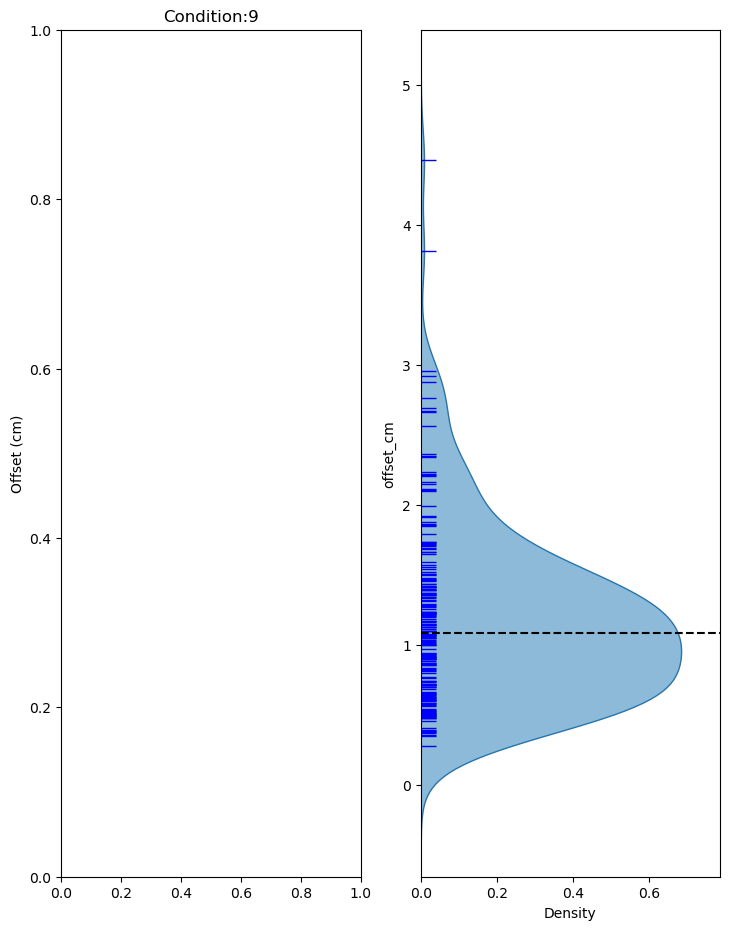

In [33]:
fig, ax = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches((8.5, 11), forward=False)


# Loop thru each condition
count_plots = 0
summary_df_all = []

for name, i in df_all.groupby('condition'):
    
    # df for all subjects for each condition
    summary_df = []    
   
    # Loop thru each subject and unique dot
    for _, j in i.groupby(['subj_nr', 'unique_dot']):
        
        # Get median gaze for each unique dot in pixels
        j['median_pred_x'] = j.user_pred_px_x_scaled.median()
        j['median_pred_y'] = j.user_pred_px_y_scaled.median()
        
        # Get euclidean distance from each gaze sample to median gaze for each dot
        j['eucl_dist_gaze_to_median_px'] = np_euclidean_distance(np.array([j.user_pred_px_x_scaled, j.user_pred_px_y_scaled]).T, 
                              np.array([j.median_pred_x, j.median_pred_y]).T)        
        j['eucl_dist_gaze_to_median_cm'] = j.eucl_dist_gaze_to_median_px * scale_cm_in_px
        
        # Get euclidean distance from median gaze to ground truth (accuracy)
        j['offset_px'] = np_euclidean_distance(np.array([j.median_pred_x, j.median_pred_y]).T, np.array([j.x_scaled, j.y_scaled]).T)  
        j['offset_cm'] = j.offset_px * scale_cm_in_px
        
        summary_df.append(j)        
    
    # Concatenate datasets from all subjects  
    summary_df = pd.concat(summary_df)
    
    # Get STD (mean distance of gaze_to_median per subject)
    agg_SD = summary_df.groupby(['subj_nr'])[['eucl_dist_gaze_to_median_cm']].mean().reset_index()
    
    # Get offset
    agg_OFFSET = summary_df.groupby(['subj_nr'])[['offset_cm']].mean().reset_index()
    
    # Plot offset per subject 
    sns.kdeplot(y=agg_OFFSET.offset_cm, ax=ax[1], fill=True, alpha=0.5)
    # Plot individual points
    sns.rugplot(y=agg_OFFSET.offset_cm, ax=ax[1], height=0.05, color="b")
    median_data = agg_OFFSET.offset_cm.median()
    plt.axhline(median_data, color='k', linestyle='--', linewidth=1.5, label=f'Mean: {median_data:.2f}')
    
    ax[0].title.set_text(f'Condition:{i.condition.iloc[0]}')
    ax[0].set_ylabel('Offset (cm)')
    sns.boxplot(y=agg_OFFSET.offset_cm, ax=ax[0])
    
    ax[0].set_ylim(-0.5,5)
    ax[1].set_ylim(-0.5,5)
    # ax[0].scatter(np.ones(agg_OFFSET.offset_cm.size),agg_OFFSET.offset_cm, alpha=0.5)
    # ax[0].scatter(1,agg_OFFSET.offset_cm.mean())

    # sns.violinplot(y=agg_OFFSET.offset_cm, ax=ax[1], palette='muted')
    
    # Plot SD per subject
    # ax[1].title.set_text(f'Condition:{i.condition.iloc[0]}')
    # ax[1].set_ylabel('SD (cm)')
    # ax[1].set_ylim(0,4.5)
    # ax[1].scatter(np.ones(agg_SD.eucl_dist_gaze_to_median_cm.size),agg_SD.eucl_dist_gaze_to_median_cm, alpha=0.5)
    # ax[1].scatter(1,agg_SD.eucl_dist_gaze_to_median_cm.mean())        
    
    count_plots += 1
    
    # accumulate all dfs across conditions
    summary_df_all.append(summary_df)

# Concatenate datasets across conditions
summary_df_all = pd.concat(summary_df_all)
    
# Save plot
fig.tight_layout()
fig.suptitle(f'N={df_all.subj_nr.unique().size}', fontsize=16)
fig.subplots_adjust(top=0.9)
# fig.savefig('summary.jpg', dpi=1000)


### T-tests

In [ ]:
# T-tests offset
offset = summary_df_all.groupby(['subj_nr','condition']).offset_cm.mean()
offset = offset.unstack()

print('*** Offset summary ***')
print(offset.mean())
print('\n')
print('T-Test: 13 vs. 9')
print(stats.ttest_rel(np.array(offset['13']), np.array(offset['9'])))
print('T-Test: 25_13 vs. 25_9:')
print(stats.ttest_rel(np.array(offset['25_13']), np.array(offset['25_9'])))

# T-tests SD
SD = summary_df_all.groupby(['subj_nr','condition']).eucl_dist_gaze_to_median_cm.mean()
SD = SD.unstack()
print('\n')
print('*** SD summary ***')
print(SD.mean())
print('\n')
print('T-Test: 13 vs. 9')
print(stats.ttest_rel(np.array(SD['13']), np.array(SD['9'])))
print('T-Test: 25_13 vs. 25_9:')
print(stats.ttest_rel(np.array(SD['25_13']), np.array(SD['25_9'])))    

offset_cutoff = 3.0
print('\n')
print(f'*** For whom is calibration offset greater than {offset_cutoff}cm? ***')
x = offset.reset_index()
x.where((x['13'] > offset_cutoff) | (x['9'] > offset_cutoff))


*** Offset summary ***
condition
9    1.192187
dtype: float64


T-Test: 13 vs. 9


KeyError: '13'

### Overview of participants and the number of included gaze samples

In [ ]:
# Participant descriptive statistics (gaze samples per participant)
descr_stats = summary_df_all.groupby(['platform', 'subj_nr', 'sona_pp_id'])['unique_dot'].count().reset_index()
print(f'Descriptive Stats:\n {descr_stats}')

### Average number of unique dots per condition

In [ ]:
# Participant descriptive statistics (gaze samples per participant)
descr_stats = summary_df_all.groupby(['condition','subj_nr','unique_dot'])['offset_cm'].count().reset_index()
descr_stats2 = descr_stats.groupby(['condition', 'subj_nr']).unique_dot.count().reset_index()
descr_stats2 = descr_stats2.groupby('condition').unique_dot.mean()
print(f'Mean unique dots:\n {descr_stats2}')

### How many calibration attempts for 9 and 13 conditions?

In [ ]:
num_calib_attempts_df.groupby('num_calib_dots').frequency.mean()

### To do
1. Summarize the incomplete datasets (failed calibration, other reasons)